# PlasticParcels Example
## The pathways and fate of Italian coastal plastic pollution
In this example, we will use `PlasticParcels` to run a basic simulation of microplastic pollution along the Italian coastline.

In [29]:
# Library imports
from datetime import datetime, timedelta
import xarray as xr

# Parcels and PlasticParcels imports
from parcels import ParticleFile, JITParticle, Variable
from PlasticParcels import constructors, utils
import PlasticParcels as PP

# Plotting imports
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Load the model settings
settings_file = 'PlasticParcels/lorenz_settings.json'
settings = PP.utils.load_settings(settings_file)

In [3]:
# Create the simulation settings
settings['simulation'] = {
    'start_date': datetime.strptime('2019-01-10-00:00:00', '%Y-%m-%d-%H:%M:%S'), # Start date of simulation
    'runtime': timedelta(days=90),             # Runtime of simulation, use negative if releasing particles backwards in time
    'dt_write': timedelta(hours=12),             # Timestep of output
    'dt_timestep': timedelta(minutes=20),       # Timestep of advection
    }

# Overwrite some settings
settings['mode'] = '2D'
settings['biofouling_f'] = False
settings['stokes_f'] = True
settings['wind_f'] = True


In [4]:
# Create the particle release settings
settings['release'] = {
    'wind_coefficient' : 0.01, # Percentage of wind to apply to particles
    'plastic_diameter' : 0.001, # Plastic particle diameter (m)
    'plastic_density' : 1030., # Plastic particle density (kg/m^3)
    'initialisation_type': 'coastal',
    'country': 'Italy',   
}

In [5]:
settings['ocean']['indices'] = {'lon':range(3300, 4000), 'lat':range(1850, 2400)}#, 'depth':range(0,2)}

In [6]:
# Create the fieldset
fieldset = PP.constructors.create_fieldset(settings)
fieldset.computeTimeChunk()

21600.0

/nethome/denes001/.conda/envs/parcels-v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


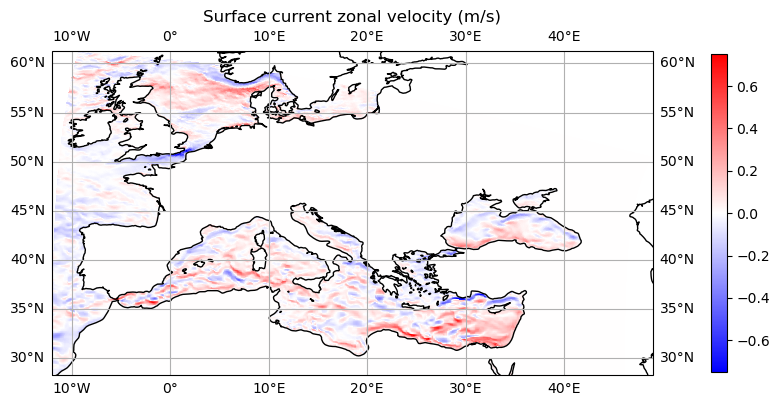

In [22]:
fig = plt.figure(figsize=(10, 5.5))
ax=plt.subplot(111, projection=ccrs.PlateCarree())
cbar = ax.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0,0,:,:], transform=ccrs.PlateCarree(), cmap=plt.cm.bwr, vmin=-0.75, vmax=0.75)
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title('Surface current zonal velocity (m/s)')
plt.colorbar(cbar,shrink=0.75, pad=0.075)
plt.show()

/nethome/denes001/.conda/envs/parcels-v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


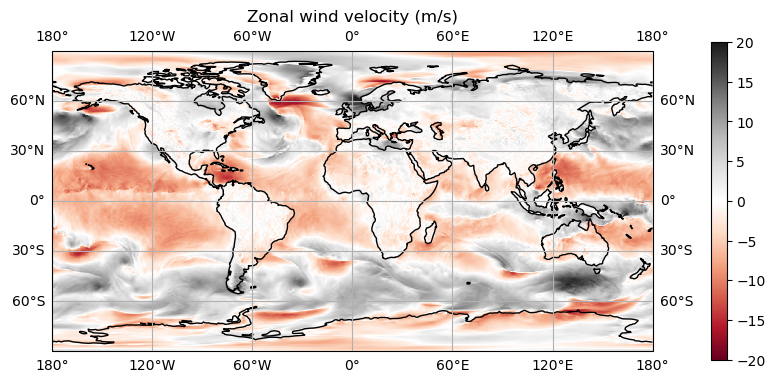

In [28]:
fig = plt.figure(figsize=(10, 5.5))
ax=plt.subplot(111, projection=ccrs.PlateCarree())
cbar = ax.pcolormesh(fieldset.Wind_U.grid.lon, fieldset.Wind_U.grid.lat, fieldset.Wind_U.data[0,:,:], transform=ccrs.PlateCarree(), cmap=plt.cm.RdGy, vmin=-20, vmax=20)
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title('Zonal wind velocity (m/s)')
plt.colorbar(cbar,shrink=0.75, pad=0.075)
plt.show()

In [6]:
# Create the fieldset
fieldset = PP.constructors.create_fieldset(settings)

In [7]:
# Create the particleset
pset = PP.constructors.create_particleset_from_map(fieldset, settings)

In [8]:
# Create the applicable kernels to the plastic particles
kernels = PP.constructors.create_kernel(fieldset)

In [9]:
# Define the runtime, the timestepping, and the output frequency of the simulation from the settings
runtime = settings['simulation']['runtime']
dt_timestep = settings['simulation']['dt_timestep']
dt_write = settings['simulation']['dt_write']

In [10]:
# Create the particle file where output will be stored
pfile = ParticleFile('example_Italy_coast.zarr', pset, outputdt=dt_write)
pfile.add_metadata('PlasticParcels_settings', str(settings))

In [11]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt_timestep, output_file=pfile)

INFO: Output files are stored in example_Italy_coast.zarr.
100%|██████████| 7776000.0/7776000.0 [02:29<00:00, 52115.41it/s]


In [30]:
import xarray as xr
ds = xr.open_zarr('example_Italy_coast.zarr')

In [13]:
ds.plastic_amount

<xarray.DataArray 'plastic_amount' (trajectory: 664, obs: 180)>
dask.array<open_dataset-plastic_amount, shape=(664, 180), dtype=float32, chunksize=(664, 1), chunktype=numpy.ndarray>
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 172 173 174 175 176 177 178 179
  * trajectory  (trajectory) int64 0 1 2 3 4 5 6 ... 657 658 659 660 661 662 663
Attributes:
    long_name:      
    standard_name:  plastic_amount
    units:          unknown

In [33]:
import numpy as np

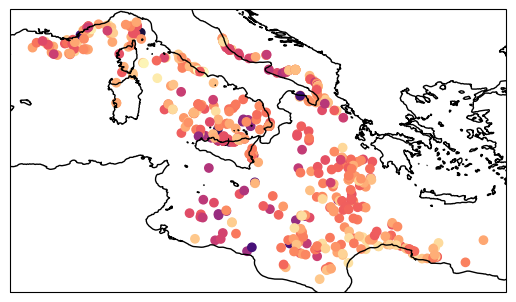

In [37]:
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.coastlines(zorder=20)
ax.scatter(ds['lon'].T[-1], ds['lat'].T[-1], c = np.log10(ds['plastic_amount'].T[0]), transform=ccrs.PlateCarree(), cmap=plt.cm.magma)

plt.show()

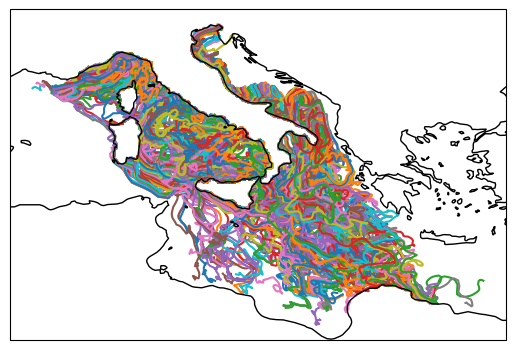

In [30]:
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.coastlines(zorder=20)
ax.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree())

plt.show()

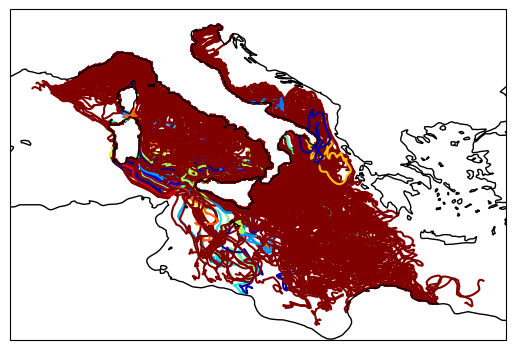

In [41]:
import numpy as np
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.coastlines(zorder=20)
minval = np.min(ds['plastic_amount'].T[0,:])
maxval = np.max(ds['plastic_amount'].T[0,:])
for i in range(len(ds['plastic_amount'].T[0,:])):
    ax.plot(ds['lon'].T[:,i], ds['lat'].T[:,i], c=plt.cm.jet(ds['plastic_amount'].T[0,i]), transform=ccrs.PlateCarree())
plt.show()

In [39]:
ds['plastic_amount'].T[0,:].values

array([4.55093346e+01, 4.54099274e+01, 4.53344307e+01, 5.08740196e+01,
       5.08516808e+01, 1.33532196e+02, 1.33215363e+02, 9.16013870e+01,
       9.15836182e+01, 4.99231033e+01, 4.99006500e+01, 2.32261353e+01,
       4.71537971e+01, 4.70459213e+01, 3.04711461e-01, 3.04128677e-01,
       6.10566318e-01, 2.97017021e+01, 1.73047507e+00, 2.51469631e+01,
       1.08091569e+00, 1.73601615e+00, 1.73269618e+00, 4.09976274e-01,
       5.46682396e+01, 6.08425789e+01, 1.99269447e+01, 1.73534667e+00,
       5.45422974e+01, 5.44425545e+01, 1.01787791e-01, 7.26059377e-01,
       6.09407387e+01, 1.99545593e+01, 1.98774014e+01, 1.33709788e+00,
       1.33451986e+00, 3.79424973e+01, 1.33193040e+00, 1.28525722e+00,
       3.05266380e-02, 3.58483493e-01, 6.79608464e-01, 1.25172210e+00,
       5.34273148e+01, 1.24931681e+00, 1.24689972e+00, 5.33201714e+01,
       1.37714291e+00, 4.04236364e+00, 4.03455019e+00, 9.16587925e+00,
       3.79242821e+01, 4.89836991e-01, 1.62064910e+00, 1.61751640e+00,
      

In [24]:
ds['plastic_amount'].T[0].values.shape

(664,)

In [27]:
kernels

[<function PlasticParcels.kernels.PolyTEOS10_bsq(particle, fieldset, time)>,
 <function parcels.application_kernels.advection.AdvectionRK4_3D(particle, fieldset, time)>,
 <function PlasticParcels.kernels.SettlingVelocity(particle, fieldset, time)>,
 <function PlasticParcels.kernels.checkThroughBathymetry(particle, fieldset, time)>,
 <function PlasticParcels.kernels.checkErrorThroughSurface(particle, fieldset, time)>,
 <function PlasticParcels.kernels.periodicBC(particle, fieldset, time)>,
 <function PlasticParcels.kernels.deleteParticle(particle, fieldset, time)>]